#### 表中数据的特征
+ Glucose： 血浆 葡萄糖 浓度， 采用 2 小时 口服 葡萄糖 耐 量 试验 测得。 
    * Pregnancies： 怀孕 的 次数。 
    * BloodPressure： 舒张 压（ 毫米 汞 柱）。 
    * SkinThickness： 肱 三头肌 皮肤 褶皱 厚度（ 毫米）。 
    * Insulin： 两个 小时 血清 胰岛素（ μ U/ 毫升）。 
+ BMI： 身体 质量 指数， 体重 除以 身高 的 平方。 
    * Diabetes Pedigree Function： 糖尿病 血统 指数， 糖尿病 和 家庭 遗传 相关。 
    * Age： 年龄。 Diabetes Pedigree Function

### 数据集获取与处理(数据集的划分[训练集,测试集])

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# 加载数据
data = pd.read_csv('datasets/pima-indians-diabetes/diabetes.csv')
print(type(data))  # pandas.core.frame.DataFrame
print('dataset shape {}'.format(data.shape))
data.head()   # 获取数据的头5行

<class 'pandas.core.frame.DataFrame'>
dataset shape (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.groupby("Outcome").size()  # 以是否患有糖尿病 进行统计,并且计算各自的大小,其中阴性样本500例，阳性样本268例

Outcome
0    500
1    268
dtype: int64

In [4]:
# 把数据集划分为 训练集和测试集
X = data.iloc[:, 0:8]  # iloc 隐形取值和切片  所有行，前8列数据  
Y = data.iloc[:, 8]   # 所有行，取最后一列   
# Y = data.ix[:, 8]
"""
.ix弃用
.loc用于基于标签的索引
.iloc位置索引
"""
print('shape of X {}; shape of Y {}'.format(X.shape, Y.shape))

shape of X (768, 8); shape of Y (768,)


In [5]:
# 把数据集划分为 训练集和测试集 导入train_test_split函数对数据集进行拆分
# 该函数有3个参数  输入X  输出Y  测试集所占比例
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(Y_train))
print(np.shape(Y_test))

(614, 8)
(154, 8)
(614,)
(154,)


###  构造三个模型

In [6]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
# 构造三个模型
models = []

models.append(("KNN", KNeighborsClassifier(n_neighbors=2)))   # 普通的k均值算法 
models.append(("KNN with weights", KNeighborsClassifier(
    n_neighbors=2, weights="distance")))   # 带权重的k均值算法
models.append(("Radius Neighbors", RadiusNeighborsClassifier(
    n_neighbors=2, radius=500.0)))   # 指定半径的k均值算法

### 分别训练三个模型  并进行评分

In [7]:
results = []
# 从模型集合中遍历出 模型名 和模型对应的方法  
for name, model in models:
    model.fit(X_train, Y_train)   # 将X_train作为训练数据集  Y_train作为目标值进行拟合模型
    results.append((name, model.score(X_test, Y_test)))  # 将模型名称 和 准确率 添加到results列表中

# 遍历结果，将其打印出来
for i in range(len(results)):
    print("name: {}; score: {}".format(results[i][0],results[i][1]))
    

name: KNN; score: 0.7077922077922078
name: KNN with weights; score: 0.6558441558441559
name: Radius Neighbors; score: 0.6883116883116883


### 结果分析
* 从结果中可以分析出来，普通的K均值算法准确率还是最高的，由于所用的数据集和训练集都是随机生成的，故此时还不能说明普通K均值一定最好

### 解决办法
* 此时，采用多次随机分配训练数据集和交叉验证数据集，然后求模型准确性评分的平均值。
    * K折交叉验证：sklearn.model_selection.KFold(n_splits=3, shuffle=False, random_state=None)
    * 思路：将训练/测试数据集划分n_splits个互斥子集，每次用其中一个子集当作验证集，剩下的n_splits-1个作为训练集，进行n_splits次训练和测试，得到n_splits个结果

    * 注意点：对于不能均等份的数据集，其前n_samples % n_splits子集拥有n_samples // n_splits + 1个样本，其余子集都只有n_samples // n_splits样本

    * 参数说明：

    n_splits：表示划分几等份

    shuffle：在每次划分时，是否进行洗牌

        ①若为Falses时，其效果等同于random_state等于整数，每次划分的结果相同

        ②若为True时，每次划分的结果都不一样，表示经过洗牌，随机取样的

    random_state：随机种子数

*  cross_val_score(estimator, X, Y, cv)
    * estimator：估算器对象实现'适合'
        用于拟合数据的对象。
    * cv：int，交叉验证生成器或可迭代的，可选的

    确定交叉验证拆分策略。cv的可能输入是：

    无，使用默认的3倍交叉验证，
    整数，指定折叠数。
    要用作交叉验证生成器的对象。
    可迭代的屈服列车/测试分裂。

In [8]:
# sktlearn 提供了这两种方法，可以直接调用计算
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

results = []
for name, model in models:
    # 通过 KFold 把数据集分成10份，其中1份会作为交叉验证数据集 来计算模型准确性，剩余的9份作为 训练数据集。
    kfold = KFold(n_splits=10)  
    print(kfold)
    # cross_val_score（）函数总共计算出10 次不同训练数据集和交叉验证数据集组合得到的  模型准确性评分，最后求平均值。
    cv_result = cross_val_score(model, X, Y, cv=kfold)  # 模型  训练数据集  目标值  交叉验证生成器或可迭代的  cross_val_score会计算出准确率
    print(cv_result)
    results.append((name, cv_result))
    
for i in range(len(results)):
    print("name: {}; cross val score: {}".format(
        results[i][0],results[i][1].mean()))  # mean() 求平均值

KFold(n_splits=10, random_state=None, shuffle=False)
[ 0.5974026   0.80519481  0.64935065  0.67532468  0.71428571  0.74025974
  0.84415584  0.75324675  0.67105263  0.69736842]
KFold(n_splits=10, random_state=None, shuffle=False)
[ 0.55844156  0.74025974  0.61038961  0.62337662  0.7012987   0.71428571
  0.76623377  0.72727273  0.63157895  0.69736842]
KFold(n_splits=10, random_state=None, shuffle=False)
[ 0.5974026   0.71428571  0.54545455  0.5974026   0.64935065  0.61038961
  0.81818182  0.67532468  0.68421053  0.60526316]
name: KNN; cross val score: 0.7147641831852358
name: KNN with weights; cross val score: 0.6770505809979495
name: Radius Neighbors; cross val score: 0.6497265892002735


### 分析结果
通过不同数据集和交叉验证集 最后求平均 可以得到更为准确的结果

从结果中看出普通的K均值算法模型 性能更好，故采用此算法模型进行模型训练

## 模型训练

In [9]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, Y_train)
train_score = knn.score(X_train, Y_train)   # 计算训练集的k模型算法的准确率
test_score = knn.score(X_test, Y_test)  
print("train score: {}; test score: {}".format(train_score, test_score))

train score: 0.8534201954397395; test score: 0.7077922077922078


* 从上面的这个输出结果中可以看到两个问题。
    * 一是对训练样本train的拟合情况不佳，评分才0. 83多一些，这说明算法模型太简单了，无法很好地拟合训练样本。
    * 二是模型的准确性欠佳，不到68% 的预测准确性。
    * 从下面的可视化图中可以看出。模型欠拟合


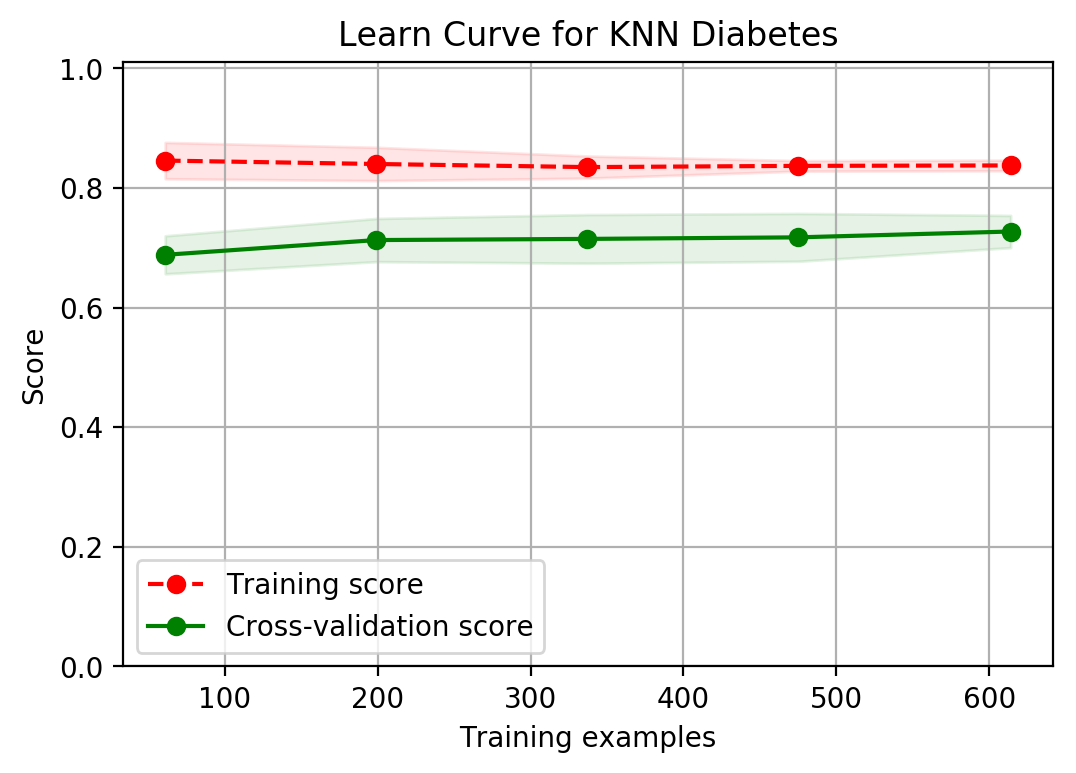

In [10]:
from sklearn.model_selection import ShuffleSplit   # ShuffleSplit数据划分的一种方法 随机划分
from common.utils import plot_learning_curve

# 利用K分类器 对数据进行
knn = KNeighborsClassifier(n_neighbors=2)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plt.figure(figsize=(6, 4), dpi=200)
plot_learning_curve(plt, knn, "Learn Curve for KNN Diabetes", 
                    X, Y, ylim=(0.0, 1.01), cv=cv);

## 数据可视化

In [11]:
from sklearn.feature_selection import SelectKBest
#  sklearn.feature_selection 提供了丰富的 特征值选取 方法
#  下面使用sklearn.feature_selection里面的SelectKBest 来选择相关性最大的两个值

selector = SelectKBest(k=2)
# 把相关性最大的2个数据存放到X_new中
# fit_transform()的作用就是先拟合数据，然后转化它将其转化为标准形式
X_new = selector.fit_transform(X, Y)
# 取出前5个数据样本
X_new[0:5]

array([[ 148. ,   33.6],
       [  85. ,   26.6],
       [ 183. ,   23.3],
       [  89. ,   28.1],
       [ 137. ,   43.1]])

In [12]:
#  仅仅使用者2个相关性最大的特征   3种不同的k均值算法的准确性  从结果可以看出，普通的k均值算法的准确性还是最高的，拟合的模型最优
results = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model, X_new, Y, cv=kfold)
    results.append((name, cv_result))
for i in range(len(results)):
    print("name: {}; cross val score: {}".format(
        results[i][0],results[i][1].mean()))

name: KNN; cross val score: 0.725205058099795
name: KNN with weights; cross val score: 0.6900375939849623
name: Radius Neighbors; cross val score: 0.6510252904989747


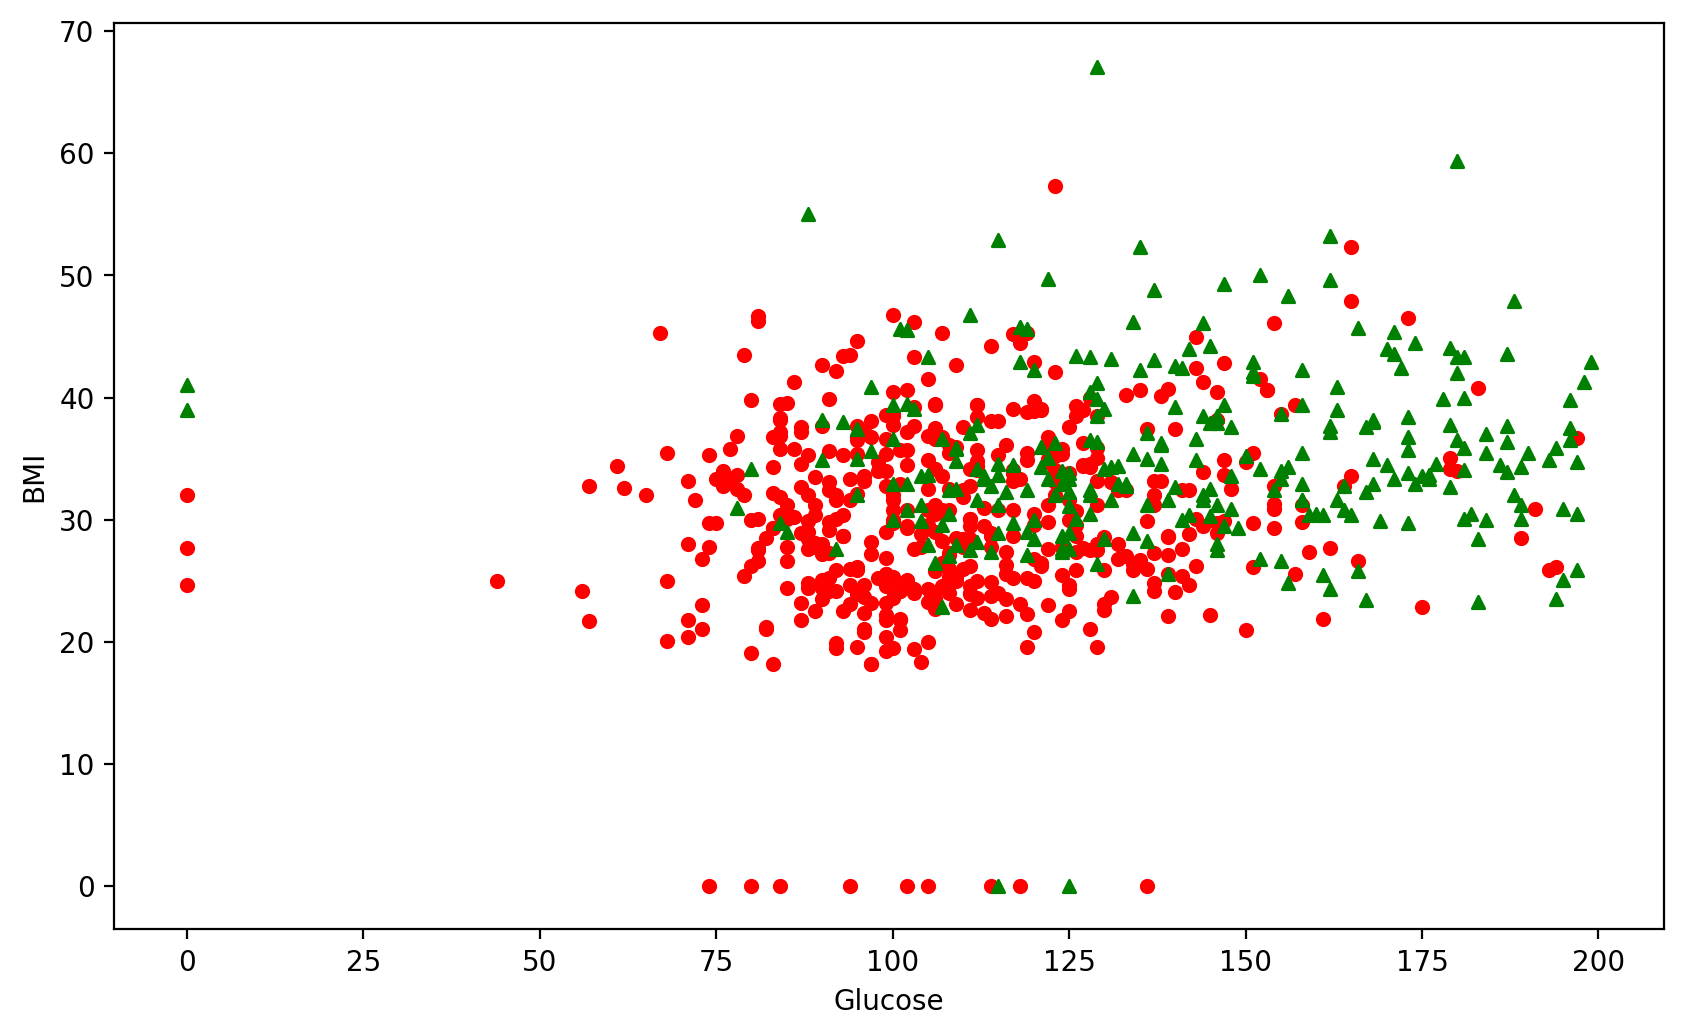

In [13]:
# 画出2个特征值的数据 用散点图来表示
plt.figure(figsize=(10, 6), dpi=200)
plt.ylabel("BMI")
plt.xlabel("Glucose")
plt.scatter(X_new[Y==0][:, 0], X_new[Y==0][:, 1], c='r', s=20, marker='o');         # 画出Y==0阴性的样本  圆
plt.scatter(X_new[Y==1][:, 0], X_new[Y==1][:, 1], c='g', s=20, marker='^');         # 画出阳性的样本 三角形

### 结果分析
* 横坐标是血糖值，纵坐标是BMI值
    * 反映身体肥胖情况。 从图中可以看出， 在中间数据集密集的区域，阳性样本和阴性样本几乎重叠在一起了。 
    * 假设现在有一个待预测的样本在中间密集区域，它的阳性邻居多还是阴性邻居多很难说（很难预测）。
    * 从图中可以直观地看到，k-均值算法在这个糖尿病预测问题上， 无法达到很高的预测准确性。

* k-均值算法在这个案例中无法很好的预测准确性
